# Setup Code

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# imports
import torch
import torch.nn.functional as F
import numpy as np
import sys
import os
from matplotlib import pyplot as plt

In [4]:
# select devices
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Bad to go!")
    DEVICE = torch.device("cpu")

Good to go!


Load config from config files.

In [5]:
# load config
sys.path.append(os.getcwd())
# choose between ship, lego
import configs.ship, configs.lego
sample_t: tuple = (2,6)
scale_factor = 3
# change config file here
config = configs.lego

Load the dataset and show the first one.

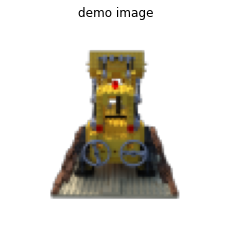

and its pose: 
[[-9.99902189e-01  4.19224519e-03 -1.33457193e-02 -5.37983216e-02]
 [-1.39886811e-02 -2.99659073e-01  9.53943670e-01  3.84547043e+00]
 [-4.65661287e-10  9.54037189e-01  2.99688309e-01  1.20808232e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [6]:
from nerf.data import load_blender
imgs, poses, int_mat = load_blender(config.datadir, device=DEVICE, scale_factor=scale_factor)
img_n, img_h, img_w = imgs.shape[:3]
# visualize
plt.imshow(np.array(imgs[0].to(device="cpu")))
plt.axis("off")
plt.title("demo image")
plt.show()
print("and its pose: ")
print(np.array(poses[0].to(device="cpu")))

# Test Functions

In [7]:
# compute rays
from nerf.graphics import compute_rays

rays_o, rays_d = compute_rays((img_h, img_w), int_mat, poses[0])
print("origin: ", rays_o[0,0])
print("normalized origin: ", F.normalize(rays_o[0,0], dim=0))
print("center of ray: ", rays_d[img_h//2,img_w//2])

origin:  tensor([-0.0538,  3.8455,  1.2081], device='cuda:0')
normalized origin:  tensor([-0.0133,  0.9539,  0.2997], device='cuda:0')
center of ray:  tensor([ 0.0133, -0.9539, -0.2997], device='cuda:0')


In [8]:
# query from rays
from nerf.graphics import queries_from_rays
samples = None
samples, depths = queries_from_rays(rays_o, rays_d, sample_t, 8)
print("samples[0, 0]: ", samples[0,0])
print("depths: ", depths)

samples[0, 0]:  tensor([[ 0.8732,  1.2320,  1.3163],
        [ 1.0013,  0.8707,  1.3313],
        [ 1.2108,  0.2800,  1.3557],
        [ 1.4087, -0.2780,  1.3788],
        [ 1.7013, -1.1029,  1.4130],
        [ 1.9005, -1.6645,  1.4363],
        [ 2.1449, -2.3536,  1.4648],
        [ 2.2813, -2.7383,  1.4807]], device='cuda:0')
depths:  tensor([[[2.4731, 2.8150, 3.3739,  ..., 5.2139, 5.8660, 6.2300],
         [2.2976, 2.6760, 3.5606,  ..., 5.2339, 5.6100, 6.4267],
         [2.4825, 2.8357, 3.3003,  ..., 5.2465, 5.8496, 6.2720],
         ...,
         [2.2792, 2.7547, 3.1929,  ..., 5.0869, 5.7032, 6.0170],
         [2.1788, 2.7903, 3.4541,  ..., 5.0918, 5.4661, 6.1068],
         [2.0966, 2.9714, 3.5599,  ..., 5.0307, 5.7165, 6.1610]],

        [[2.4455, 2.8601, 3.5516,  ..., 4.8953, 5.8526, 6.3939],
         [2.3435, 2.9421, 3.2634,  ..., 5.2817, 5.5171, 6.0682],
         [2.0760, 2.9848, 3.2168,  ..., 4.9912, 5.5477, 6.0513],
         ...,
         [2.1605, 2.7781, 3.2186,  ..., 5.1110

In [9]:
# test pos encode

from nerf.nerf_helper import *

L = 6
x = torch.tensor([[ 1.8013, -0.6242,  0.7009]])
# x = torch.tensor([ 1.8013, -0.6242,  0.7009])
enc_x = PosEncode(x, L, True)
# enc_xx = PosEncode1(x, L, True)
print(enc_x)
# print(enc_xx)




tensor([[ 1.8013,  0.9736, -0.2285, -0.4449, -0.8956,  0.7968,  0.6042,  0.9629,
         -0.2698, -0.5197, -0.8544,  0.8880,  0.4599, -0.6242, -0.5844,  0.8114,
         -0.9485,  0.3168, -0.6010, -0.7992,  0.9607,  0.2775,  0.5332, -0.8460,
         -0.9022,  0.4313,  0.7009,  0.6449,  0.7643,  0.9858,  0.1682,  0.3316,
         -0.9434, -0.6257,  0.7801, -0.9762,  0.2171, -0.4238, -0.9057]])


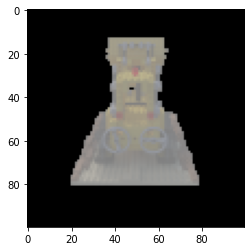

In [10]:
# test render from nerf
from nerf.graphics import render_from_nerf
fake_depth = torch.Tensor([1])
fake_nerf_output = imgs[0].cpu().reshape(img_h, img_w, 1, 4)
rgb, depth = render_from_nerf(fake_nerf_output, fake_depth)
plt.imshow(rgb)
plt.show()

# Train

In [11]:
# One iteration of TinyNeRF (forward pass).
# TODO train
# raise Exception("nothing wrong")


No checkpoint found
train_it: 0 img_idx:  23 loss: 0.20240726455856944
pred[50,50]: tensor([0.5447, 0.5389, 0.5016], device='cuda:0', grad_fn=<SelectBackward0>)
Iteration  0
Val loss:  tensor(0.1524, device='cuda:0', grad_fn=<MseLossBackward0>)


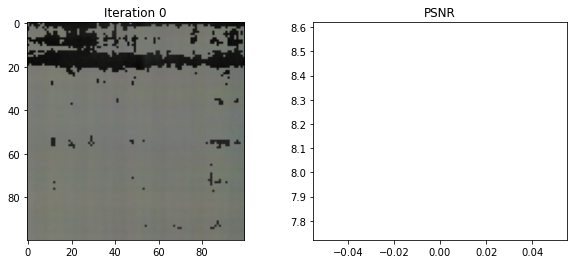

train_it: 1 img_idx:  36 loss: 0.16978312527136513
pred[50,50]: tensor([0.4567, 0.4706, 0.4522], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 2 img_idx:  56 loss: 0.10304011193776681
pred[50,50]: tensor([0.3885, 0.4109, 0.3720], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 3 img_idx:  87 loss: 0.09141744690083355
pred[50,50]: tensor([0.2748, 0.3434, 0.3050], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 4 img_idx:  48 loss: 0.09190751227401306
pred[50,50]: tensor([0.2657, 0.3251, 0.2690], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 5 img_idx:  67 loss: 0.048349088099534906
pred[50,50]: tensor([0.2409, 0.2848, 0.2378], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 6 img_idx:  85 loss: 0.028486820557343293
pred[50,50]: tensor([0.1616, 0.2104, 0.1666], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 7 img_idx:  22 loss: 0.07330247881671265
pred[50,50]: tensor([0.1121, 0.1464, 0.1088], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 8

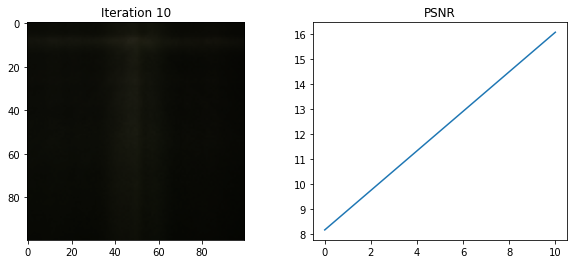

train_it: 11 img_idx:  41 loss: 0.019705760707513627
pred[50,50]: tensor([0.0826, 0.0860, 0.0520], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 12 img_idx:  57 loss: 0.06437235803496104
pred[50,50]: tensor([0.1061, 0.1023, 0.0590], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 13 img_idx:  57 loss: 0.06241888962292816
pred[50,50]: tensor([0.1266, 0.1149, 0.0649], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 14 img_idx:  4 loss: 0.05509955296276024
pred[50,50]: tensor([0.0798, 0.0665, 0.0331], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 15 img_idx:  19 loss: 0.08373283424389508
pred[50,50]: tensor([0.1076, 0.0820, 0.0415], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 16 img_idx:  97 loss: 0.04360746186975475
pred[50,50]: tensor([0.0979, 0.0667, 0.0284], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 17 img_idx:  14 loss: 0.06679847320808889
pred[50,50]: tensor([0.1498, 0.0982, 0.0426], device='cuda:0', grad_fn=<SelectBackward0>)
train_

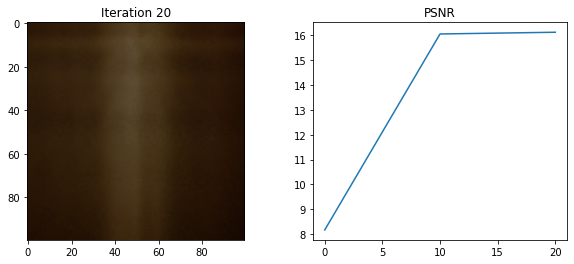

train_it: 21 img_idx:  33 loss: 0.1046881176194355
pred[50,50]: tensor([0.2683, 0.1878, 0.0944], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 22 img_idx:  47 loss: 0.05801520208644127
pred[50,50]: tensor([0.3447, 0.2840, 0.1736], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 23 img_idx:  55 loss: 0.0713008583907055
pred[50,50]: tensor([0.2920, 0.2164, 0.1123], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 24 img_idx:  76 loss: 0.07008973829096554
pred[50,50]: tensor([0.3549, 0.2998, 0.1898], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 25 img_idx:  28 loss: 0.09761474105751586
pred[50,50]: tensor([0.2736, 0.2208, 0.1195], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 26 img_idx:  40 loss: 0.0310850116147314
pred[50,50]: tensor([0.2120, 0.1678, 0.0735], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 27 img_idx:  47 loss: 0.05466464779342021
pred[50,50]: tensor([0.3369, 0.3131, 0.2002], device='cuda:0', grad_fn=<SelectBackward0>)
train_it:

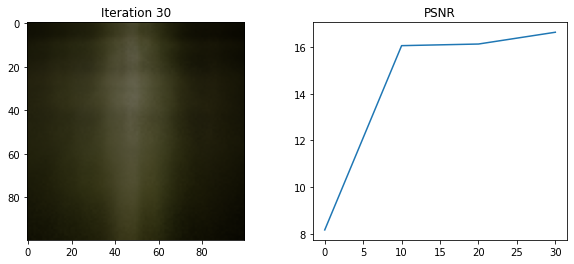

train_it: 31 img_idx:  16 loss: 0.0515023215759702
pred[50,50]: tensor([0.1771, 0.1741, 0.0836], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 32 img_idx:  56 loss: 0.0529008574562435
pred[50,50]: tensor([0.2675, 0.2728, 0.1630], device='cuda:0', grad_fn=<SelectBackward0>)
train_it: 33 img_idx:  62 loss: 0.05602819781372388
pred[50,50]: tensor([0.1817, 0.1873, 0.1021], device='cuda:0', grad_fn=<SelectBackward0>)


In [13]:
from nerf.model import NeRF, TinyNeRF
from nerf.nerf_helper import nerf_iter_once, tinynerf_iter_once
import os.path

# parameters
L_pos = 6
L_dir = 4
num_samples = 32

chunksize = 512
lr = 5e-3
betas=(0.9, 0.999)
num_it = 10000
display_every = 10

# load validation data
# imgs_val, poses_val, int_mat_val = load_blender(config.datadir, data_type="val",scale_factor=2, device=DEVICE)
# num_val = imgs_val.shape[0]

# models
# model = NeRF(ch_in_pos=6*L_pos, ch_in_dir=6*L_dir, fc_width=64, fc_depth=4, skips=[2])
model = TinyNeRF(6*L_pos+3, fc_width=128)
model.to(DEVICE)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    # betas=betas,
)
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)
ckpt_path = 'nerf.pt'

# val
val_idx = 0
val_img = imgs[val_idx].to(DEVICE)
val_c2w = poses[val_idx]

# train
psnrs = []
its = []
i = 0

# check saved checkpoints
# if os.path.exists(ckpt_path):
if False:
    print("checkpoint found! Loading...")
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    i = checkpoint['epoch']
    loss = checkpoint['loss']
    psnrs = checkpoint['psnrs']
    its = checkpoint['its']
    print("checkpoint loaded, i =",i)
else:
    print("No checkpoint found")

for i in range(i, num_it):
    gt_img_idx = np.random.randint(100)
    gt_img = imgs[gt_img_idx].to(DEVICE)
    gt_c2w = poses[gt_img_idx]

    pred_rgb,_ = tinynerf_iter_once(
                model,
                (img_h, img_w),
                int_mat,
                gt_c2w,
                sample_t,
                num_samples=num_samples
                )
    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(pred_rgb, gt_img[...,:3])

    # plt.imshow(pred_rgb.detach().cpu().numpy())
    # plt.show()
    # plt.imshow(gt_img[...,:3].detach().cpu().numpy())
    # plt.show()
    print("train_it:", i, "img_idx: ", gt_img_idx, "loss:",float(loss))
    print("pred[50,50]:",pred_rgb[50,50])
    loss.backward()
    optimizer.step()

    if i % display_every == 0:
        # val_idx = np.random.randint(num_val)
        # val_img = imgs_val[val_idx].to(DEVICE)
        # val_c2w = poses_val[val_idx]

        pred_rgb,_ = tinynerf_iter_once(
                model,
                (img_h, img_w),
                int_mat,
                val_c2w,
                sample_t,
                num_samples=num_samples,
                batch_size=chunksize
                )

        loss = torch.nn.functional.mse_loss(pred_rgb, val_img[...,:3])
        print("Iteration ", i)
        print("Val loss: ", loss)

        psnr = -10. * torch.log10(loss)
        psnrs.append(psnr.item())
        its.append(i)

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        img_np = pred_rgb.detach().cpu().numpy()
        plt.imshow(img_np)
        plt.title(f"Iteration {i}")
        plt.subplot(122)
        plt.plot(its, psnrs)
        plt.title("PSNR")
        plt.show()

        torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'psnr': psnrs,
            'its': its
            }, ckpt_path)